In [2]:
# ライブラリのインポート
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [4]:
# 交通量データの読込み
timeseries_aug = np.load("./train_data_aug.npy")
timeseries_sep = np.load("./train_data_sep.npy")

In [5]:
# 読み込んだ交通量データの確認（トラカン_8月交通量）
timeseries_aug

array([[  292,    13,  2260, ...,   635,  1803,  6945],
       [  216,    15,  1343, ...,   440,  1121,  4578],
       [  172,    15,  1208, ...,   439,  1112,  4229],
       ...,
       [  784,    64,  7708, ...,  1372,  6088, 25568],
       [  485,    35,  4806, ...,  1103,  4146, 17256],
       [  350,    25,  3459, ...,   761,  2537, 12569]], dtype=int64)

In [6]:
# 読み込んだ交通量データの確認（トラカン_9月交通量）
timeseries_sep

array([[  225,    18,  2210, ...,   601,  1670,  8832],
       [  231,    22,  1623, ...,   513,  1298,  6897],
       [  170,    18,  1267, ...,   504,  1140,  5324],
       ...,
       [ 1018,    76, 10608, ...,  1748,  8355, 33992],
       [  846,    66,  6708, ...,  1656,  5503, 24457],
       [  817,    28,  4701, ...,  1118,  3747, 16469]], dtype=int64)

# LSTMのためのデータを準備

In [7]:
# データの正規化
# データを0～1の範囲に正規化）
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(timeseries_aug)
scaled_data

array([[0.03208868, 0.00603622, 0.04872051, ..., 0.03773301, 0.04050225,
        0.05038653],
       [0.01730844, 0.01006036, 0.01050263, ..., 0.00841852, 0.00718194,
        0.0161838 ],
       [0.00875146, 0.01006036, 0.00487622, ..., 0.00826819, 0.00674223,
        0.01114081],
       ...,
       [0.1277713 , 0.10865191, 0.27577728, ..., 0.14852676, 0.24985343,
        0.31948559],
       [0.06962271, 0.05030181, 0.15483037, ..., 0.10808779, 0.15497362,
        0.19937866],
       [0.04336834, 0.03018109, 0.09869134, ..., 0.05667468, 0.0763631 ,
        0.13165234]])

In [8]:
# データサイズの確認
scaled_data.shape

(744, 7)

In [9]:
# トレーニングデータの大きさを取得
# 全体の80%をトレーニングデータとして扱う）
training_data_len = int(np.ceil(len(timeseries_aug) * .8))

In [10]:
# トレーニングデータの大きさを確認
training_data_len

596

In [11]:
# どれくらいの期間を基に予測するか　（例：★ここでは24時間　window_size = 24）
window_size = 24
train_data = scaled_data[0:int(training_data_len), :]
train_data

array([[0.03208868, 0.00603622, 0.04872051, ..., 0.03773301, 0.04050225,
        0.05038653],
       [0.01730844, 0.01006036, 0.01050263, ..., 0.00841852, 0.00718194,
        0.0161838 ],
       [0.00875146, 0.01006036, 0.00487622, ..., 0.00826819, 0.00674223,
        0.01114081],
       ...,
       [0.67989109, 0.64788732, 0.95790614, ..., 0.80487072, 0.9587649 ,
        0.95046601],
       [0.58459743, 0.55533199, 0.83954322, ..., 0.654089  , 0.80867696,
        0.88509501],
       [0.36775574, 0.22736419, 0.63807619, ..., 0.40980156, 0.62380301,
        0.65544397]])

In [12]:
# データサイズの確認
train_data.shape

(596, 7)

In [13]:
# train_dataを（学習データ：x_train）と（正解データ：y_train）に分ける
x_train, y_train = [], []
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, :])
    y_train.append(train_data[i, :])

In [14]:
# データの確認（学習データ：x_train）
x_train[0:2]

[array([[3.20886814e-02, 6.03621730e-03, 4.87205135e-02, 4.58654407e-02,
         3.77330126e-02, 4.05022474e-02, 5.03865328e-02],
        [1.73084403e-02, 1.00603622e-02, 1.05026257e-02, 1.45659398e-02,
         8.41852075e-03, 7.18194254e-03, 1.61838017e-02],
        [8.75145858e-03, 1.00603622e-02, 4.87621905e-03, 6.00264402e-03,
         8.26819002e-03, 6.74223178e-03, 1.11408135e-02],
        [1.14741346e-02, 2.81690141e-02, 9.41902142e-03, 1.21482081e-03,
         1.11244738e-02, 1.34844636e-02, 3.75695398e-04],
        [4.35628160e-02, 3.82293763e-02, 3.66758356e-02, 1.93061229e-02,
         5.77269994e-02, 3.78639828e-02, 1.54757604e-02],
        [1.52858810e-01, 6.03621730e-02, 1.19154789e-01, 9.15641413e-02,
         2.04750451e-01, 1.42857143e-01, 8.37800737e-02],
        [4.21625827e-01, 2.03219316e-01, 4.11227807e-01, 3.40328478e-01,
         5.78322309e-01, 3.99452804e-01, 2.93374756e-01],
        [7.20731233e-01, 4.30583501e-01, 9.17145953e-01, 9.28063552e-01,
         9

In [15]:
# データの確認（正解データ：y_train）
y_train[0]

array([0.03014391, 0.01006036, 0.0409269 , 0.04900968, 0.02330126,
       0.03903654, 0.07209017])

In [16]:
# 訓練（学習）データと教師（正解）データをnumpy arrayに変換
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# numpy_array変換後（訓練（学習）データ）【参考】https://qiita.com/ken_yoshi/items/4cbe3abb7d46c5252fdd
print(x_train.shape)
x_train

(572, 24, 7)


array([[[3.20886814e-02, 6.03621730e-03, 4.87205135e-02, ...,
         3.77330126e-02, 4.05022474e-02, 5.03865328e-02],
        [1.73084403e-02, 1.00603622e-02, 1.05026257e-02, ...,
         8.41852075e-03, 7.18194254e-03, 1.61838017e-02],
        [8.75145858e-03, 1.00603622e-02, 4.87621905e-03, ...,
         8.26819002e-03, 6.74223178e-03, 1.11408135e-02],
        ...,
        [1.33216647e-01, 1.02615694e-01, 2.84071018e-01, ...,
         1.62056524e-01, 2.67441860e-01, 3.18242902e-01],
        [1.03461688e-01, 8.85311871e-02, 1.66958406e-01, ...,
         1.15604330e-01, 1.61324995e-01, 1.95563904e-01],
        [4.78413069e-02, 2.41448692e-02, 8.85638076e-02, ...,
         5.65243536e-02, 8.44244675e-02, 1.25366664e-01]],

       [[1.73084403e-02, 1.00603622e-02, 1.05026257e-02, ...,
         8.41852075e-03, 7.18194254e-03, 1.61838017e-02],
        [8.75145858e-03, 1.00603622e-02, 4.87621905e-03, ...,
         8.26819002e-03, 6.74223178e-03, 1.11408135e-02],
        [1.14741346e-02, 

In [18]:
# numpy_array変換後（教師（正解）データ）【参考】https://qiita.com/ken_yoshi/items/4cbe3abb7d46c5252fdd
print(y_train.shape)
y_train

(572, 7)


array([[0.03014391, 0.01006036, 0.0409269 , ..., 0.02330126, 0.03903654,
        0.07209017],
       [0.01283547, 0.02615694, 0.02367258, ..., 0.01623572, 0.01294704,
        0.05028538],
       [0.00272268, 0.00603622, 0.00787697, ..., 0.01337943, 0.01270276,
        0.01917492],
       ...,
       [0.67989109, 0.64788732, 0.95790614, ..., 0.80487072, 0.9587649 ,
        0.95046601],
       [0.58459743, 0.55533199, 0.83954322, ..., 0.654089  , 0.80867696,
        0.88509501],
       [0.36775574, 0.22736419, 0.63807619, ..., 0.40980156, 0.62380301,
        0.65544397]])

In [19]:
# （AE）数ヵ所の観測点から全体の推測
# （モデル作成）
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 7)))
model.add(Dropout(0.2))
# (Encoder)
model.add(LSTM(64, activation='relu', return_sequences=False))
# (Bridge)
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
# (Decoder)
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(units=7)))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, x_train, batch_size=8, epochs=30)

Epoch 1/30
72/72 [==============================] - 4s 16ms/step - loss: 0.1513
Epoch 2/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0998
Epoch 3/30
72/72 [==============================] - 1s 16ms/step - loss: 0.1117
Epoch 4/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0872
Epoch 5/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0557
Epoch 6/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0212
Epoch 7/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0124
Epoch 8/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0085
Epoch 9/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0072
Epoch 10/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0061
Epoch 11/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0058
Epoch 12/30
72/72 [==============================] - 1s 16ms/step - loss: 0.0057
Epoch 13/30
72/72 [==================

In [20]:
# （add AE）前日（前時間）の交通量から翌日（次時間）の交通量を推測
# （モデル作成）
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 7)))
model.add(Dropout(0.2))
# (Encoder)
model.add(LSTM(64, activation='relu', return_sequences=False))
# (Bridge)
model.add(RepeatVector(x_train.shape[1]))
# (Decoder)
model.add(LSTM(128, activation='relu', return_sequences=True))

model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=7))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=8, epochs=30)

Epoch 1/30
72/72 [==============================] - 5s 24ms/step - loss: 0.1070
Epoch 2/30
72/72 [==============================] - 2s 24ms/step - loss: 0.0283
Epoch 3/30
72/72 [==============================] - 2s 23ms/step - loss: 0.0173
Epoch 4/30
72/72 [==============================] - 2s 24ms/step - loss: 0.0138
Epoch 5/30
72/72 [==============================] - 2s 23ms/step - loss: 0.0106
Epoch 6/30
72/72 [==============================] - 2s 23ms/step - loss: 0.0098
Epoch 7/30
72/72 [==============================] - 2s 23ms/step - loss: 0.0098
Epoch 8/30
72/72 [==============================] - 2s 23ms/step - loss: 0.0111
Epoch 9/30
72/72 [==============================] - 2s 25ms/step - loss: 0.0084
Epoch 10/30
72/72 [==============================] - 2s 25ms/step - loss: 0.0086
Epoch 11/30
72/72 [==============================] - 2s 26ms/step - loss: 0.0085
Epoch 12/30
72/72 [==============================] - 2s 24ms/step - loss: 0.0080
Epoch 13/30
72/72 [==================

In [21]:
# Normal LSTM
# （モデル作成）
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 7)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=7))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=8, epochs=30)

Epoch 1/30
72/72 [==============================] - 5s 21ms/step - loss: 0.0908
Epoch 2/30
72/72 [==============================] - 1s 20ms/step - loss: 0.0224
Epoch 3/30
72/72 [==============================] - 1s 20ms/step - loss: 0.0176
Epoch 4/30
72/72 [==============================] - 1s 20ms/step - loss: 0.0162
Epoch 5/30
72/72 [==============================] - 2s 21ms/step - loss: 0.0152
Epoch 6/30
72/72 [==============================] - 1s 20ms/step - loss: 0.0119
Epoch 7/30
72/72 [==============================] - 1s 20ms/step - loss: 0.0108
Epoch 8/30
72/72 [==============================] - 1s 20ms/step - loss: 0.0112
Epoch 9/30
72/72 [==============================] - 2s 23ms/step - loss: 0.0101
Epoch 10/30
72/72 [==============================] - 1s 20ms/step - loss: 0.0099
Epoch 11/30
72/72 [==============================] - 2s 21ms/step - loss: 0.0095
Epoch 12/30
72/72 [==============================] - 2s 21ms/step - loss: 0.0092
Epoch 13/30
72/72 [==================

In [22]:
# モデルの概要
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 24, 128)           69632     
                                                                 
 dropout_5 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_10 (LSTM)              (None, 24, 128)           131584    
                                                                 
 dropout_6 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 24, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 128)              

In [31]:
!pip install matplotlib
import matplotlib.pyplot as plt



Defaulting to user installation because normal site-packages is not writeable


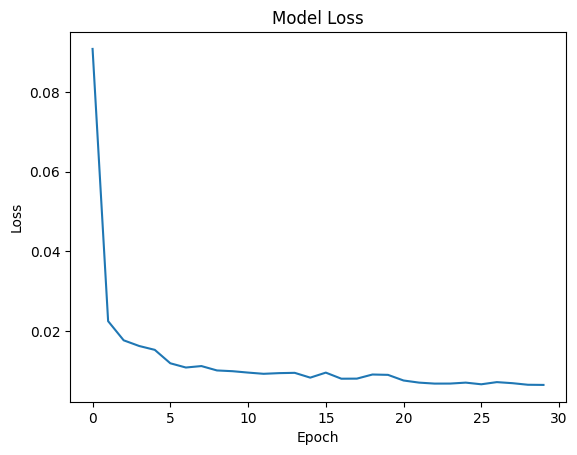

In [34]:

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


# 検証

In [35]:
# データ構造を再確認 
print(training_data_len)
print(window_size)

596
24


In [36]:
# テストデータを作成
test_data = scaled_data[training_data_len - window_size: , :]

In [37]:
# テストデータの構造を確認
test_data.shape

(172, 7)

In [38]:
# （予測用）
x_test = []
# （正解判定用）
y_test = timeseries_aug[training_data_len:, :]

In [39]:
# 正解データの構造を確認
y_test.shape

(148, 7)

In [40]:
# テスト用予測データ
for i in range(window_size, len(test_data)):
    ##  timestep 24hの場合：0 → 24, 1 → 25 ・・・
    x_test.append(test_data[i-window_size:i, :])

In [41]:
# データの確認（予測用）
x_test[0]

array([[0.21975885, 0.13480885, 0.37617738, 0.39557901, 0.24669272,
        0.34580809, 0.39696554],
       [0.1470245 , 0.10462777, 0.26448279, 0.2813263 , 0.15799759,
        0.24545632, 0.32549671],
       [0.0789576 , 0.07042254, 0.15566392, 0.18480759, 0.10748647,
        0.13728747, 0.19640199],
       [0.0521198 , 0.02615694, 0.09193965, 0.09716185, 0.05847865,
        0.08325191, 0.12114732],
       [0.03169973, 0.00603622, 0.04230224, 0.05293999, 0.01428142,
        0.03630057, 0.07000939],
       [0.02042007, 0.01609658, 0.01404518, 0.02786942, 0.0078172 ,
        0.01578073, 0.04531464],
       [0.01983664, 0.01609658, 0.00937734, 0.01358932, 0.01668671,
        0.00776822, 0.02664547],
       [0.01555815, 0.01408451, 0.016004  , 0.00634803, 0.02315093,
        0.0119699 , 0.00736941],
       [0.03461688, 0.02816901, 0.03388347, 0.02571371, 0.04284426,
        0.04328708, 0.01862582],
       [0.09898872, 0.04627767, 0.10315079, 0.0783083 , 0.15348767,
        0.11393395, 0.0

In [42]:
# データの確認（正解）
y_test[0]

array([ 1265,    97, 11048, 40828,  2215,  8788, 33493], dtype=int64)

In [43]:
# numpy_arrayに変換
x_test = np.array(x_test)
print(x_test.shape)

(148, 24, 7)


In [44]:
# 予測実行
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

5/5 [==============================] - 0s 14ms/step


In [45]:
# 予測結果を確認
print(predictions.shape)
predictions

(148, 7)


array([[1.6228210e+03, 1.1533364e+02, 1.1787803e+04, ..., 2.4127278e+03,
        9.8061924e+03, 3.4524129e+04],
       [1.1681609e+03, 7.9462151e+01, 8.7777881e+03, ..., 1.7957030e+03,
        7.2464282e+03, 2.6079832e+04],
       [7.1787854e+02, 4.8670486e+01, 5.5039785e+03, ..., 1.1666700e+03,
        4.5102563e+03, 1.7380717e+04],
       ...,
       [1.1869684e+03, 8.0762695e+01, 8.9067461e+03, ..., 1.8210461e+03,
        7.3559663e+03, 2.6427457e+04],
       [7.1308972e+02, 4.8295143e+01, 5.4622158e+03, ..., 1.1598673e+03,
        4.4755571e+03, 1.7247639e+04],
       [3.0681174e+02, 2.2985073e+01, 2.0769341e+03, ..., 5.6510272e+02,
        1.7612201e+03, 7.2970151e+03]], dtype=float32)

In [46]:
# 正解データを確認
print(y_test.shape)
y_test

(148, 7)


array([[ 1265,    97, 11048, ...,  2215,  8788, 33493],
       [  826,    51,  8143, ...,  1529,  6491, 26207],
       [  583,    39,  5171, ...,  1168,  4287, 17616],
       ...,
       [  784,    64,  7708, ...,  1372,  6088, 25568],
       [  485,    35,  4806, ...,  1103,  4146, 17256],
       [  350,    25,  3459, ...,   761,  2537, 12569]], dtype=int64)

In [47]:
# 結果をそれぞれ出力
np.save('pred_lstm.npy', predictions)
np.save('correct_lstm.npy', y_test)

In [48]:
# 性能判定
# （二乗平均平方根誤差（RMSE）：０に近いほど良い）
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

2752.044777330413


In [69]:
accuracy = np.mean((np.round(predictions) == y_test))

In [70]:
accuracy

0.004826254826254826

In [71]:
loss = np.mean(((predictions - y_test) ** 2))

In [72]:
loss


7573750.456431602

In [60]:
# 性能判定
# （二乗平均平方根誤差（RMSE）：０に近いほど良い）
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(rmse)

2752.044777330413


In [62]:
# 性能判定
# （二乗平均平方根誤差（RMSE）：０に近いほど良い）
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))
print(rmse)

2752.044777330413


In [63]:
from sklearn.metrics import mean_absolute_error
# Root Mean Squared Error(RMSE)用
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(predictions, y_test))
print(rmse)

2752.044777330412


In [64]:
from sklearn.metrics import mean_squared_log_error


In [65]:
rmsle = np.sqrt(np.mean((np.log1p(y_test) - np.log1p(predictions)) ** 2))
print(rmsle)

0.19253929116322063


In [66]:
mae = np.mean(np.abs(y_test - predictions))
print(mae)

1347.2018256813403


In [67]:
mse = mean_squared_error(y_test, predictions)
print(mse)

7573750.4564315975


In [68]:
r2 = 1 - np.mean((y_test - predictions) ** 2) / np.mean((y_test - y_test.mean()) ** 2)
print(r2)

0.9854537208797088


In [57]:
# 性能判定
# （決定係数（r2）：１に近いほど良い）
r2s = r2_score(y_test, predictions)
print(r2s)

0.9592855862486943


In [ ]:
# scalerの保存
import joblib
joblib.dump(scaler, 'scaler.gz')
# 保存したScalerの読込み
# load_scaler = joblib.load('scaler.gz')

In [ ]:
# モデルの保存　⇔ モデルの読込み model = load_model('traffic_pattern.h5')
model.save('traffic_pattern.h5')

# TEST（参考）

In [23]:
# ライブラリのインポート
import pandas as pd

In [24]:
# クリップボードからデータを読み込む
test_sep = pd.read_clipboard(header=None)
# 読み込んだデータのbackupを取得しておく
test_sep_cp = test_sep.copy()
test_sep

,0,1,2,3,4,5,6
0,173,20,0,4884,515,1325,0
1,354,0,1941,6041,757,1869,5339
2,628,31,3510,11096,1530,0,9366
3,1891,109,10345,0,3888,8532,23789
4,3810,279,22800,83375,6566,18950,63807
5,0,240,22214,85593,5809,19609,71608
6,2823,0,19520,72815,5373,17483,61464
7,2873,288,18768,70037,5595,0,60649
8,2904,262,19024,0,5696,17024,59198
9,2688,235,19007,70213,5106,16262,0


In [47]:
# データの扱いについて確認
test_sep.values[0][1]

20

In [49]:
# test_dim = []
i = 0
for _ in range(len(test_sep.values[1])):
    print(test_sep.values[0][i])
    d = []
    d.append(test_sep.values[0][i])
    test_dim.append(d)
    i += 1
test_dim

173
20
1526
4884
515
1325
4620


[[173],
 [20],
 [1526],
 [4884],
 [515],
 [1325],
 [4620],
 [173],
 [20],
 [1526],
 [4884],
 [515],
 [1325],
 [4620]]

In [26]:
# モデル作成の際に作成したscalerを利用する
scaled_sep = scaler.transform(test_sep)
scaled_sep

array([[ 8.94593543e-03,  2.01207243e-02, -4.54697008e-02,
         1.21243881e-02,  1.96933253e-02,  1.71487200e-02,
        -4.99674879e-02],
       [ 4.41462466e-02, -2.01207243e-02,  3.54255230e-02,
         2.59042674e-02,  5.60733614e-02,  4.37267930e-02,
         2.71801170e-02],
       [ 9.74329055e-02,  4.22535211e-02,  1.00816871e-01,
         8.61093577e-02,  1.72279014e-01, -4.75864765e-02,
         8.53695542e-02],
       [ 3.43057176e-01,  1.99195171e-01,  3.85679753e-01,
        -4.60440908e-02,  5.26758870e-01,  3.69259332e-01,
         2.93779351e-01],
       [ 7.16258265e-01,  5.41247485e-01,  9.04767859e-01,
         9.46952824e-01,  9.29344558e-01,  8.78248974e-01,
         8.72032368e-01],
       [-2.46985609e-02,  4.62776660e-01,  8.80345086e-01,
         9.73369222e-01,  8.15544197e-01,  9.10445574e-01,
         9.84755437e-01],
       [ 5.24309607e-01, -2.01207243e-02,  7.68067017e-01,
         8.21183140e-01,  7.50000000e-01,  8.06576119e-01,
         8.3817643

In [52]:
# 転置
scaled_sep = scaled_sep.T

In [52]:
# データの確認
scaled_sep

array([[4.41462466e-02, 2.81690141e-02, 3.54255230e-02, 2.59042674e-02,
        5.60733614e-02, 4.37267930e-02, 2.71801170e-02],
       [9.74329055e-02, 4.22535211e-02, 1.00816871e-01, 8.61093577e-02,
        1.72279014e-01, 1.23216729e-01, 8.53695542e-02],
       [3.43057176e-01, 1.99195171e-01, 3.85679753e-01, 3.25548158e-01,
        5.26758870e-01, 3.69259332e-01, 2.93779351e-01],
       [7.16258265e-01, 5.41247485e-01, 9.04767859e-01, 9.46952824e-01,
        9.29344558e-01, 8.78248974e-01, 8.72032368e-01],
       [5.75845974e-01, 4.62776660e-01, 8.80345086e-01, 9.73369222e-01,
        8.15544197e-01, 9.10445574e-01, 9.84755437e-01],
       [5.24309607e-01, 5.43259557e-01, 7.68067017e-01, 8.21183140e-01,
        7.50000000e-01, 8.06576119e-01, 8.38176432e-01],
       [5.34033450e-01, 5.59356137e-01, 7.36725848e-01, 7.88097138e-01,
        7.83373422e-01, 7.76089506e-01, 8.26399827e-01],
       [5.40062233e-01, 5.07042254e-01, 7.47395182e-01, 7.96672344e-01,
        7.98556825e-01, 7

In [45]:
# データサイズの確認
print(scaled_sep.shape)

(24, 7)


In [27]:
# データ構造の変形（第２引数：timesteps）
scaled_sep_cp = scaled_sep.reshape([1, 24, 7]).copy()

In [57]:
test_cp = scaled_sep_cp.copy()

In [56]:
print(scaled_sep_cp[0][0])
scaled_sep_cp

[0.04414625 0.02816901 0.03542552 0.02590427 0.05607336 0.04372679
 0.02718012]


array([[[4.41462466e-02, 2.81690141e-02, 3.54255230e-02, 2.59042674e-02,
         5.60733614e-02, 4.37267930e-02, 2.71801170e-02],
        [9.74329055e-02, 4.22535211e-02, 1.00816871e-01, 8.61093577e-02,
         1.72279014e-01, 1.23216729e-01, 8.53695542e-02],
        [3.43057176e-01, 1.99195171e-01, 3.85679753e-01, 3.25548158e-01,
         5.26758870e-01, 3.69259332e-01, 2.93779351e-01],
        [7.16258265e-01, 5.41247485e-01, 9.04767859e-01, 9.46952824e-01,
         9.29344558e-01, 8.78248974e-01, 8.72032368e-01],
        [5.75845974e-01, 4.62776660e-01, 8.80345086e-01, 9.73369222e-01,
         8.15544197e-01, 9.10445574e-01, 9.84755437e-01],
        [5.24309607e-01, 5.43259557e-01, 7.68067017e-01, 8.21183140e-01,
         7.50000000e-01, 8.06576119e-01, 8.38176432e-01],
        [5.34033450e-01, 5.59356137e-01, 7.36725848e-01, 7.88097138e-01,
         7.83373422e-01, 7.76089506e-01, 8.26399827e-01],
        [5.40062233e-01, 5.07042254e-01, 7.47395182e-01, 7.96672344e-01,
         7

In [29]:
# 予測実行
tst_predictions = model.predict(scaled_sep_cp)
# 正規化されたデータを逆変換
tst_predictions = scaler.inverse_transform(tst_predictions[0])
print(tst_predictions.shape)

1/1 [==============================] - 0s 10ms/step
(24, 7)


In [30]:
# 予測結果の確認
tst_predictions

array([[4.14064545e+02, 2.90722637e+01, 2.25904395e+03, 7.77320312e+03,
        7.85979248e+02, 1.99832031e+03, 6.69679834e+03],
       [5.25523682e+02, 3.05863018e+01, 2.67376782e+03, 8.30749121e+03,
        1.02283252e+03, 2.35872754e+03, 6.70195459e+03],
       [1.11466516e+03, 5.66776237e+01, 5.69913525e+03, 1.69694414e+04,
        2.01710913e+03, 4.61449902e+03, 1.28511533e+04],
       [2.24757739e+03, 1.20845650e+02, 1.22735762e+04, 3.99592930e+04,
        3.83995850e+03, 9.69190234e+03, 3.04780312e+04],
       [3.24628174e+03, 1.95476456e+02, 1.87787793e+04, 6.76019844e+04,
        5.50004688e+03, 1.58294180e+04, 5.34347578e+04],
       [3.44377686e+03, 2.33080185e+02, 2.01853828e+04, 7.46112812e+04,
        5.76194092e+03, 1.75629199e+04, 6.15271602e+04],
       [3.53268384e+03, 2.59879730e+02, 2.01699434e+04, 7.38211250e+04,
        5.75242285e+03, 1.75734336e+04, 6.19937812e+04],
       [3.53088086e+03, 2.75668854e+02, 2.02746738e+04, 7.35569141e+04,
        5.73583496e+03, 1

In [31]:
# 次元削減
i = 0
for _ in tst_predictions:
    print(tst_predictions[i])
    i += 1

[ 414.06454    29.072264 2259.044    7773.203     785.97925  1998.3203
 6696.7983  ]
[ 525.5237     30.586302 2673.7678   8307.491    1022.8325   2358.7275
 6701.9546  ]
[ 1114.6652      56.677624  5699.1353   16969.441     2017.1091
  4614.499    12851.153   ]
[ 2247.5774    120.84565 12273.576   39959.293    3839.9585   9691.902
 30478.031  ]
[ 3246.2817    195.47646 18778.78    67601.984    5500.047   15829.418
 53434.758  ]
[ 3443.7769    233.08018 20185.383   74611.28     5761.941   17562.92
 61527.16   ]
[ 3532.6838    259.87973 20169.943   73821.125    5752.423   17573.434
 61993.78   ]
[ 3530.8809    275.66885 20274.674   73556.914    5735.835   17617.785
 61937.523  ]
[ 3438.5444    285.07135 20182.814   72659.38     5583.5625  17408.098
 60958.203  ]
[ 3349.919     297.40326 20055.082   71908.055    5401.1147  17161.17
 60038.97   ]
[ 3299.3071   315.8077 20028.457  71894.81    5275.8843 17030.762
 59761.69  ]
[ 3288.1804    336.58206 20203.17    72396.875    5251.2847  17024

In [87]:
for cnt in range(24):
    if cnt == 0:
        scaled_sep = scaler.transform(test_sep)
        scaled_sep = scaled_sep.reshape([1, 24, 7])
    
    tst_prediction = model.predict(scaled_sep)
    np.append(scaled_sep, tst_prediction)
    np.delete(scaled_sep, 0, 1)

1/1 [==============================] - 0s 12ms/step


In [88]:
scaled_sep[0]

array([[ 8.94593543e-03,  2.01207243e-02, -4.54697008e-02,
         1.21243881e-02,  1.96933253e-02,  1.71487200e-02,
        -4.99674879e-02],
       [ 4.41462466e-02, -2.01207243e-02,  3.54255230e-02,
         2.59042674e-02,  5.60733614e-02,  4.37267930e-02,
         2.71801170e-02],
       [ 9.74329055e-02,  4.22535211e-02,  1.00816871e-01,
         8.61093577e-02,  1.72279014e-01, -4.75864765e-02,
         8.53695542e-02],
       [ 3.43057176e-01,  1.99195171e-01,  3.85679753e-01,
        -4.60440908e-02,  5.26758870e-01,  3.69259332e-01,
         2.93779351e-01],
       [ 7.16258265e-01,  5.41247485e-01,  9.04767859e-01,
         9.46952824e-01,  9.29344558e-01,  8.78248974e-01,
         8.72032368e-01],
       [-2.46985609e-02,  4.62776660e-01,  8.80345086e-01,
         9.73369222e-01,  8.15544197e-01,  9.10445574e-01,
         9.84755437e-01],
       [ 5.24309607e-01, -2.01207243e-02,  7.68067017e-01,
         8.21183140e-01,  7.50000000e-01,  8.06576119e-01,
         8.3817643

In [89]:
result = scaler.inverse_transform(scaled_sep[0])
result

array([[1.7300e+02, 2.0000e+01, 0.0000e+00, 4.8840e+03, 5.1500e+02,
        1.3250e+03, 0.0000e+00],
       [3.5400e+02, 0.0000e+00, 1.9410e+03, 6.0410e+03, 7.5700e+02,
        1.8690e+03, 5.3390e+03],
       [6.2800e+02, 3.1000e+01, 3.5100e+03, 1.1096e+04, 1.5300e+03,
        0.0000e+00, 9.3660e+03],
       [1.8910e+03, 1.0900e+02, 1.0345e+04, 0.0000e+00, 3.8880e+03,
        8.5320e+03, 2.3789e+04],
       [3.8100e+03, 2.7900e+02, 2.2800e+04, 8.3375e+04, 6.5660e+03,
        1.8950e+04, 6.3807e+04],
       [0.0000e+00, 2.4000e+02, 2.2214e+04, 8.5593e+04, 5.8090e+03,
        1.9609e+04, 7.1608e+04],
       [2.8230e+03, 0.0000e+00, 1.9520e+04, 7.2815e+04, 5.3730e+03,
        1.7483e+04, 6.1464e+04],
       [2.8730e+03, 2.8800e+02, 1.8768e+04, 7.0037e+04, 5.5950e+03,
        0.0000e+00, 6.0649e+04],
       [2.9040e+03, 2.6200e+02, 1.9024e+04, 0.0000e+00, 5.6960e+03,
        1.7024e+04, 5.9198e+04],
       [2.6880e+03, 2.3500e+02, 1.9007e+04, 7.0213e+04, 5.1060e+03,
        1.6262e+04, 0.0

In [91]:
# 次元削減
i = 0
for _ in result:
    print(result[i])
    i += 1

[ 173.   20.    0. 4884.  515. 1325.    0.]
[ 354.    0. 1941. 6041.  757. 1869. 5339.]
[  628.    31.  3510. 11096.  1530.     0.  9366.]
[ 1891.   109. 10345.     0.  3888.  8532. 23789.]
[ 3810.   279. 22800. 83375.  6566. 18950. 63807.]
[    0.   240. 22214. 85593.  5809. 19609. 71608.]
[ 2823.     0. 19520. 72815.  5373. 17483. 61464.]
[ 2873.   288. 18768. 70037.  5595.     0. 60649.]
[ 2904.   262. 19024.     0.  5696. 17024. 59198.]
[ 2688.   235. 19007. 70213.  5106. 16262.     0.]
[ 2746.     0. 19076. 70284.  4927. 16612. 58981.]
[ 2708.   234.     0. 70876.  4775. 16281. 59149.]
[ 2742.   241. 19554. 71458.  4661.     0. 61093.]
[ 2859.   318. 19546. 70548.  4392. 16757.     0.]
[ 3196.     0. 23004. 80850.  5595. 18733. 67620.]
[ 2816.   270.     0. 79615.  4589. 17277. 64834.]
[ 1825.   139. 15664.     0.  3062. 12631. 48671.]
[ 1122.    82. 10579. 39396.  1917.     0. 33901.]
[  720.    64.  7147.     0.  1445.  5787. 25041.]
[  556.    36.  4996. 18821.     0.  3713. 17

In [60]:
predictions_traffic_volume = []
for cnt in range(22):
    scaled_sep = scaler.transform(tst_predictions)
    scaled_sep = scaled_sep.reshape([1, 1, 7])
    tst_predictions = model.predict(scaled_sep)
    tst_predictions = scaler.inverse_transform(tst_predictions)
    predictions_traffic_volume.append(tst_predictions[0])

1/1 [==============================] - 0s 22ms/step


In [61]:
predictions_traffic_volume

[array([ 348.22058 ,   24.645567, 2143.605   , 7345.1494  ,  685.5027  ,
        1804.0275  , 6990.9937  ], dtype=float32),
 array([ 390.33563,   27.25305, 2441.0457 , 8352.528  ,  753.3081 ,
        2040.0591 , 7798.4707 ], dtype=float32),
 array([ 438.9829 ,   30.28612, 2784.3926 , 9517.267  ,  831.3926 ,
        2313.42   , 8733.56   ], dtype=float32),
 array([  504.8319  ,    34.448986,  3248.126   , 11095.034   ,
          937.28467 ,  2684.371   ,  9998.706   ], dtype=float32),
 array([  603.40094 ,    40.734795,  3940.6895  , 13457.377   ,
         1095.3954  ,  3239.2908  , 11892.586   ], dtype=float32),
 array([  733.0388  ,    49.004856,  4852.4404  , 16570.465   ,
         1303.6483  ,  3970.0933  , 14390.978   ], dtype=float32),
 array([  909.0682 ,    60.30736,  6089.3354 , 20797.84   ,  1586.4325 ,
         4963.183  , 17784.416  ], dtype=float32),
 array([ 1141.0236  ,    76.093605,  7710.932   , 26371.502   ,
         1957.9976  ,  6281.646   , 22260.418   ], dtype=floa